## Get Cuda and Processor information

In [1]:
import sys
sys.path.append('../Submodular')

import DeviceDir

DIR, RESULTS_DIR = DeviceDir.get_directory()
device, NUM_PROCESSORS = DeviceDir.get_device()

NUM_PROCESSORS

32

In [2]:
import multiprocessing

NUM_PROCESSORS=multiprocessing.cpu_count()
print("Cpu count: ",NUM_PROCESSORS)

Cpu count:  32


In [3]:
from ipynb.fs.full.Dataset import get_data
from ipynb.fs.full.Dataset import datasets as available_datasets
from ipynb.fs.full.Utils import save_plot

In [4]:
import argparse
from argparse import ArgumentParser

#set default arguments here
def get_configuration():
    parser = ArgumentParser()
    parser.add_argument('--epochs', type=int, default=1)
    parser.add_argument('--log_info', type=bool, default=True)
    parser.add_argument('--pbar', type=bool, default=False)
    parser.add_argument('--batch_size', type=int, default=2048)
    parser.add_argument('--learning_rate', type=float, default=0.01)
    parser.add_argument('--recompute', type=bool, default=False)
    parser.add_argument('--num_gpus', type=int, default=-1)
    parser.add_argument('--parallel_mode', type=str, default="dp", choices=['dp', 'ddp', 'ddp2'])
    parser.add_argument('--dataset', type=str, default="Cora", choices=available_datasets)
    parser.add_argument('--use_normalization', action='store_false', default=True)
    parser.add_argument('-f') ##dummy for jupyternotebook
    args = parser.parse_args()
    
    dict_args = vars(args)
    
    return args, dict_args

args, dict_args = get_configuration()

## libraries

In [5]:
import random
import numpy as np
import torch

seed = 123

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
None

In [6]:
import os
import math
import time
from tqdm import tqdm
import torch.nn as nn
from torch_geometric.data import Data, Dataset

## GNN model

In [7]:
import torch_geometric
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, GINConv, ChebConv
from torch_geometric.nn import GraphConv, TransformerConv
from torch_geometric.utils import degree
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from ipynb.fs.full.SpatialConv import SpatialConv

### GNN option 1

In [8]:
GNNconv = SAGEConv

In [9]:
class GNNHomophily(torch.nn.Module):
    def __init__(self, num_features,num_classes, hidden_channels=16):
        super().__init__()
        self.num_classes = num_classes
             
        self.conv1 = GNNconv(num_features, hidden_channels)
        #self.conv2 = GNNconv(hidden_channels,hidden_channels)
        self.conv3 = GNNconv(hidden_channels,num_classes)

    def forward(self, x, edge_index, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
#         x = self.conv2(x, edge_index, edge_weight)
#         x = x.relu()
#         x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index, edge_weight)
        
        return x
    
class GNNHeterophily(torch.nn.Module):
    def __init__(self, num_features,num_classes, hidden_channels=16):
        super().__init__()
        self.num_classes = num_classes
             
        self.conv1 = ChebConv(num_features, hidden_channels, K=2, normalization='sym')
        #self.conv2 = GNNconv(hidden_channels,hidden_channels)
        self.conv3 = ChebConv(hidden_channels,num_classes, K=2, normalization='sym')

    def forward(self, x, edge_index, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
#         x = self.conv2(x, edge_index, edge_weight)
#         x = x.relu()
#         x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index, edge_weight)
        
        return x
    
class AGSGNN(torch.nn.Module):
    def __init__(self, num_features,num_classes, hidden_channels=16, dropout=0.5):
        super().__init__()
        self.num_classes = num_classes
        
        hidden = int(hidden_channels/2)
        
        #self.gnn1 = GNNHomophily(num_features, num_classes, hidden_channels)        
        self.gnn1 = GNNHomophily(num_features, hidden, hidden_channels)
        self.gnn2 = GNNHeterophily(num_features, hidden, hidden_channels)
        self.p = dropout
        self.com_lin = nn.Linear(hidden*2, num_classes)
        
        
#         self.T = 2        
#         self.layer_norm_a1 =  nn.LayerNorm(num_classes)
#         self.layer_norm_s1 =  nn.LayerNorm(num_classes)
        
#         self.alpha_a1 = nn.Linear(num_classes, 1)
#         self.alpha_s1 = nn.Linear(num_classes, 1)
#         self.w1 = nn.Linear(self.T, self.T)
        
        #self.reset_parameters()
            
#     def reset_parameters(self):
#         std_att = 1. / math.sqrt(self.w1.weight.size(1))
#         std_att_vec = 1. / math.sqrt( self.alpha_a1.weight.size(1))
        
#         self.alpha_s1.weight.data.uniform_(-std_att, std_att)
#         self.alpha_i1.weight.data.uniform_(-std_att, std_att)
        
#         self.layer_norm_a1.reset_parameters()
#         self.layer_norm_s1.reset_parameters()        
        
    def forward(self, batch_data):
        
        #out = model(batch_data.x, batch_data.edge_index, batch_data.weight)
        #out = model(batch_data.x, batch_data.edge_index, batch_data.edge_weight)
        #out = model(batch_data.x, batch_data.edge_index)
        
        x1 = self.gnn1(batch_data[0].x, batch_data[0].edge_index)
        #return x1        
        
        x2 = self.gnn2(batch_data[1].x, batch_data[1].edge_index)
        #return x2
        
        a1 = F.relu(x1)
        #a1 = self.layer_norm_a1(a1)
        a1 = F.dropout(a1, p=self.p, training=self.training)
        
        s1 = F.relu(x2)
        #s1 = self.layer_norm_s1(s1)
        s1 = F.dropout(s1, p=self.p, training=self.training)
        
        used = batch_data[0].batch_size
        
        x = torch.cat([a1[:used,:], s1[:used,:]], dim=-1)
        x = self.com_lin(x)
        
        
#         ala1 = torch.sigmoid(self.alpha_a1(a1))
#         als1 = torch.sigmoid(self.alpha_s1(s1))        
        
#         alpha1 = F.softmax(self.w1(torch.cat([ala1, als1],dim=-1)/self.T), dim=1)                
#         x = torch.mm(torch.diag(alpha1[:,0]),a1) + torch.mm(torch.diag(alpha1[:,1]),s1)
        
        #print(x.shape)
        
        return x

## GNN Training and Testing

In [10]:
from torch_geometric.loader import NeighborSampler, NeighborLoader
from ipynb.fs.full.AGSNodeSampler import WeightedNeighborLoader

In [11]:
def test(model, loader, mask, name='Train'):    
    if args.log_info:    
        pbar = tqdm(total=sum(mask).item())
        pbar.set_description(f'Evaluating {name}')
    
    model.eval()
    
    total_correct=0
    total_examples=0
    
    sigmoid = nn.Sigmoid()    
    
    y_true = []
    y_pred = []
    
    with torch.no_grad():                  
    
        for i,batch_data in enumerate(loader):
            
            batch_data = [b.to(device) for b in batch_data]
            used = batch_data[0].batch_size
            
            out = model(batch_data)
                   
            out=out[:used,:]
            pred = out.argmax(dim=1)            

            y_true.append(batch_data[0].y[:used].detach().cpu().numpy())
            y_pred.append(pred.detach().cpu().numpy())
            
            if args.log_info:
                pbar.update(used)
              
    if args.log_info:
        pbar.close()
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    
    acc = accuracy_score(y_true, y_pred)
                    
    return acc

In [12]:
def train(DATASET_NAME, model, data, epochs=100, train_neighbors=[-1,10], test_neighbors=[-1,10]):
    
    if args.log_info:
        print("Train neighbors: ", train_neighbors)
        print("Test neighbors: ", test_neighbors)
        
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    optimizer = torch.optim.Adam(model.parameters())
    
    if data.y.ndim == 1:
        criterion = torch.nn.CrossEntropyLoss()
    else:
        criterion = torch.nn.BCEWithLogitsLoss()
    
    #batch_size=1024         
    batch_size=512         
    worker = 0
    
    if data.num_nodes>=50000:
        worker = 8
    else:
        worker = min(8,int(sum(data.train_mask)/batch_size))
        
    if args.log_info:
        print("Worker: ", worker)
        
#     weight_func=['knn','submodular']; 
    weight_func=['knn','submodular']; 
#     weight_func=['random', 'random'];  worker = 0;
#     weight_func=['link-nn', 'link-sub'];  worker = 2;
    params={
        'knn':{'metric':'cosine'},
        'submodular':{'metric':'cosine'},
        'link-nn':{'value':'min'},
        'link-sub':{'value':'max'},
    }    
    
    sampler_dir = DIR+'AGSGNNstruc/'+DATASET_NAME
#     if not os.path.exists(sampler_dir):
#         os.makedirs(sampler_dir)
    
    start = time.time()    
    loader = WeightedNeighborLoader(data, input_nodes=data.train_mask,num_neighbors=train_neighbors, 
                              batch_size=batch_size, shuffle=True, num_workers=worker, drop_last=False, 
                              weight_func=weight_func, params=params, log=args.log_info,
                                    directed=True, replace = False,
                                    save_dir = sampler_dir,recompute = args.recompute)

    train_loader = WeightedNeighborLoader(data, input_nodes=data.train_mask,num_neighbors=train_neighbors, 
                              batch_size=batch_size, shuffle=False, num_workers=worker, drop_last=False, 
                              weight_func=weight_func, params=params, log=args.log_info,
                                          directed=True, replace = False,
                                          save_dir = sampler_dir,recompute = False)
    
    val_loader = WeightedNeighborLoader(data, input_nodes=data.val_mask,num_neighbors=test_neighbors, 
                              batch_size=batch_size, shuffle=False, num_workers=min(8,int(sum(data.val_mask)/batch_size)), drop_last=False, 
                              weight_func=weight_func, params=params,log=args.log_info, directed=True, replace = False,
                                        save_dir = sampler_dir,recompute = False)
    
    test_loader = WeightedNeighborLoader(data, input_nodes=data.test_mask,num_neighbors=test_neighbors, 
                              batch_size=batch_size, shuffle=False, num_workers=min(8,int(sum(data.test_mask)/batch_size)), drop_last=False, 
                              weight_func=weight_func, params=params, log=args.log_info, directed=True, replace = False,
                                         save_dir = sampler_dir,recompute = False)
    
    top_k_accs = []    
    best_acc=0  
    
    train_losses=[]
    val_accuracies=[]
    train_accuracies=[]
    test_accuracies=[]
    
    num_iteration = epochs
    
    end = time.time()
    if args.log_info:
        print("Total initialization time: ", end-start)
    
    start = time.time()
    
    for epoch in range(1,epochs+1):
        
        if args.log_info:
            pbar = tqdm(total=int(sum(data.train_mask)))
            pbar.set_description(f'Epoch {epoch:02d}')
        
        model.train()
        total_loss = total_examples = 0
        
        for i,batch_data in enumerate(loader):            
            #print(batch_data)
            
            batch_data = [b.to(device) for b in batch_data]
            used = batch_data[0].batch_size #int(sum(batch_data.train_mask))       
            
            optimizer.zero_grad()            
            out = model(batch_data)
            #out = F.log_softmax(out, dim=1)                 
            #loss = F.nll_loss(out[batch_data[0].train_mask], batch_data[0].y[batch_data[0].train_mask])
            #loss = F.cross_entropy(out[:used], batch_data[0].y[:used])
            loss = criterion(out[:used], batch_data[0].y[:used])
            
            loss.backward()
            optimizer.step()
                        
            total_loss += loss.item() * used
            total_examples += used
            
            if args.log_info:
                pbar.update(used)
        if args.log_info:
            pbar.close()
        
        loss=total_loss / total_examples
        train_losses.append(loss)
        
        #print(f'Epoch: {epoch:03d}, Train Loss: {loss:.4f}', end = ', ')                
        
        if args.log_info:
            train_acc=test(model, train_loader,data.train_mask,'Train')            
            train_accuracies.append(train_acc.item())        
        else:
            train_acc = 0 ; train_accuracies.append(train_acc)
        
        if args.log_info:
            val_acc = test(model, val_loader,data.val_mask,'Validation')
            val_accuracies.append(val_acc.item())
        else:
            val_acc = 0 ; val_accuracies.append(val_acc)

        test_acc = test(model, test_loader,data.test_mask,'Test')
        test_accuracies.append(test_acc.item())
        #print(f'Epoch: {epoch:03d}, Test: {test_acc:.4f}')
        
        std_dev = np.std(train_losses[-5:])
        #print(f'Epoch: {epoch:03d}, Std dev: {std_dev:.4f}')
        
        if args.log_info:
            print(f'Epoch: {epoch:03d}, Train Loss: {loss:.4f}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}, Std dev: {std_dev:.4f}')

        if epoch>=5 and std_dev<=1e-3:
            num_iteration = epoch
            
            if args.log_info:                
                print("Iteration for convergence: ", epoch)
            break
        
    if args.log_info:
        #save_plot([val_accuracies], labels=['Validation'], name='Plots/Validation', yname='Accuracy', xname='Epoch')    
        save_plot([train_losses, train_accuracies, val_accuracies, test_accuracies], labels=['Loss','Train','Validation','Test'], name='Results/AGSNSVal', yname='Accuracy', xname='Epoch')
        
        print ("Best Validation Accuracy, ",max(val_accuracies))
        print ("Best Test Accuracy, ",max(test_accuracies))
        
    best_acc = max(test_accuracies)
    
    end = time.time()
    if args.log_info:
        print("Total epoch time: ", end-start)    
    
    return best_acc, num_iteration

In [13]:
def AGSNSperformanceSampler(DATASET_NAME, data, dataset, num_classes, epochs=1, train_neighbors=[-1,-1], test_neighbors=[-1,-1]):        
    
    model = AGSGNN(data.x.shape[1], num_classes, hidden_channels=256).to(device)
    
    if args.log_info: print(model)    
    
    best_acc, num_iteration = train(DATASET_NAME, model, data, epochs, train_neighbors=train_neighbors, test_neighbors=test_neighbors)    
    
    return best_acc, num_iteration, model

In [14]:
def adj_feature(data):    
    adj_mat = torch.zeros((data.num_nodes,data.num_nodes))
    edges = data.edge_index.t()
    adj_mat[edges[:,0], edges[:,1]] = 1
    return adj_mat

# adj_feature(data)
# data.x.shape

In [15]:
from torch_geometric.utils import add_self_loops

N  34  E  156  d  4.588235294117647 0.8020520210266113 0.7564102411270142 0.6170591711997986 -0.4756128787994385 
Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34], val_mask=[34], test_mask=[34])
AGSGNN(
  (gnn1): GNNHomophily(
    (conv1): SAGEConv(34, 256)
    (conv3): SAGEConv(256, 128)
  )
  (gnn2): GNNHeterophily(
    (conv1): ChebConv(34, 256, K=2, normalization=sym)
    (conv3): ChebConv(256, 128, K=2, normalization=sym)
  )
  (com_lin): Linear(in_features=256, out_features=4, bias=True)
)
Train neighbors:  [8, 4]
Test neighbors:  [8, 4]
Worker:  0
Metric:  cosine


Nodes: 100%|██████████| 34/34 [00:00<00:00, 1867.46it/s]


saving weights  knn
Metric:  cosine


Nodes: 100%|██████████| 34/34 [00:00<00:00, 2964.79it/s]


saving weights  submodular
Total initialization time:  0.1518552303314209


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9249.42it/s]


Epoch: 001, Train Loss: 1.3961, Train: 0.2500, Val: 0.3333, Test: 0.3333, Std dev: 0.0000


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9329.66it/s]


Epoch: 002, Train Loss: 1.4303, Train: 0.5000, Val: 0.3333, Test: 0.3667, Std dev: 0.0171


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9284.23it/s]


Epoch: 003, Train Loss: 1.3439, Train: 0.5000, Val: 0.3333, Test: 0.3333, Std dev: 0.0355


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9316.53it/s]


Epoch: 004, Train Loss: 1.3946, Train: 0.5000, Val: 0.4000, Test: 0.3333, Std dev: 0.0308


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9174.56it/s]


Epoch: 005, Train Loss: 1.3289, Train: 0.5000, Val: 0.3667, Test: 0.3667, Std dev: 0.0372


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9267.13it/s]


Epoch: 006, Train Loss: 1.2810, Train: 0.5000, Val: 0.3667, Test: 0.3333, Std dev: 0.0520


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9276.70it/s]


Epoch: 007, Train Loss: 1.3341, Train: 0.7500, Val: 0.4000, Test: 0.3667, Std dev: 0.0363


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9298.63it/s]


Epoch: 008, Train Loss: 1.2248, Train: 1.0000, Val: 0.4000, Test: 0.3667, Std dev: 0.0569


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9315.85it/s]


Epoch: 009, Train Loss: 1.3107, Train: 1.0000, Val: 0.4333, Test: 0.4667, Std dev: 0.0401


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9385.33it/s]


Epoch: 010, Train Loss: 1.2437, Train: 1.0000, Val: 0.4333, Test: 0.4667, Std dev: 0.0406


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9323.44it/s]


Epoch: 011, Train Loss: 1.2564, Train: 1.0000, Val: 0.4333, Test: 0.4000, Std dev: 0.0415


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9346.29it/s]


Epoch: 012, Train Loss: 1.1962, Train: 1.0000, Val: 0.4333, Test: 0.4667, Std dev: 0.0380


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9210.83it/s]


Epoch: 013, Train Loss: 1.1847, Train: 1.0000, Val: 0.4333, Test: 0.4000, Std dev: 0.0453


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9060.28it/s]


Epoch: 014, Train Loss: 1.1438, Train: 1.0000, Val: 0.4667, Test: 0.4667, Std dev: 0.0409


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9238.56it/s]


Epoch: 015, Train Loss: 1.1975, Train: 1.0000, Val: 0.4667, Test: 0.4667, Std dev: 0.0361


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9304.82it/s]


Epoch: 016, Train Loss: 1.1577, Train: 1.0000, Val: 0.5333, Test: 0.5333, Std dev: 0.0215


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9273.96it/s]


Epoch: 017, Train Loss: 1.0870, Train: 1.0000, Val: 0.4667, Test: 0.5000, Std dev: 0.0386


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9229.75it/s]


Epoch: 018, Train Loss: 1.0742, Train: 1.0000, Val: 0.5000, Test: 0.4667, Std dev: 0.0457


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9174.56it/s]


Epoch: 019, Train Loss: 1.0688, Train: 1.0000, Val: 0.5333, Test: 0.5000, Std dev: 0.0514


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9228.39it/s]


Epoch: 020, Train Loss: 1.1028, Train: 1.0000, Val: 0.5000, Test: 0.5333, Std dev: 0.0320


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9246.70it/s]


Epoch: 021, Train Loss: 1.0123, Train: 1.0000, Val: 0.6000, Test: 0.6333, Std dev: 0.0307


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9240.59it/s]


Epoch: 022, Train Loss: 0.9858, Train: 1.0000, Val: 0.6000, Test: 0.6667, Std dev: 0.0430


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9198.71it/s]


Epoch: 023, Train Loss: 0.9680, Train: 1.0000, Val: 0.5667, Test: 0.6333, Std dev: 0.0508


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9284.23it/s]


Epoch: 024, Train Loss: 1.0004, Train: 1.0000, Val: 0.6000, Test: 0.5667, Std dev: 0.0469


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9267.81it/s]


Epoch: 025, Train Loss: 0.8990, Train: 1.0000, Val: 0.6667, Test: 0.6333, Std dev: 0.0399


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9216.90it/s]


Epoch: 026, Train Loss: 0.8743, Train: 1.0000, Val: 0.6667, Test: 0.7000, Std dev: 0.0498


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9195.35it/s]


Epoch: 027, Train Loss: 0.7585, Train: 1.0000, Val: 0.6333, Test: 0.7000, Std dev: 0.0841


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9244.66it/s]


Epoch: 028, Train Loss: 0.7748, Train: 1.0000, Val: 0.7000, Test: 0.7000, Std dev: 0.0883


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9185.95it/s]


Epoch: 029, Train Loss: 0.7783, Train: 1.0000, Val: 0.6667, Test: 0.7333, Std dev: 0.0578


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9147.22it/s]


Epoch: 030, Train Loss: 0.8096, Train: 1.0000, Val: 0.7333, Test: 0.7333, Std dev: 0.0411


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9169.88it/s]


Epoch: 031, Train Loss: 0.6915, Train: 1.0000, Val: 0.7000, Test: 0.7333, Std dev: 0.0392


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9273.28it/s]


Epoch: 032, Train Loss: 0.6315, Train: 1.0000, Val: 0.7667, Test: 0.6667, Std dev: 0.0657


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9017.42it/s]


Epoch: 033, Train Loss: 0.5581, Train: 1.0000, Val: 0.7333, Test: 0.7333, Std dev: 0.0926


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9179.92it/s]


Epoch: 034, Train Loss: 0.5613, Train: 1.0000, Val: 0.7333, Test: 0.7333, Std dev: 0.0937


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9246.02it/s]


Epoch: 035, Train Loss: 0.6034, Train: 1.0000, Val: 0.7000, Test: 0.7333, Std dev: 0.0494


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9264.40it/s]


Epoch: 036, Train Loss: 0.5590, Train: 1.0000, Val: 0.7333, Test: 0.7000, Std dev: 0.0298


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9278.75it/s]


Epoch: 037, Train Loss: 0.5507, Train: 1.0000, Val: 0.7333, Test: 0.7333, Std dev: 0.0188


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9233.81it/s]


Epoch: 038, Train Loss: 0.4602, Train: 1.0000, Val: 0.7333, Test: 0.7000, Std dev: 0.0471


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9216.90it/s]


Epoch: 039, Train Loss: 0.4250, Train: 1.0000, Val: 0.7000, Test: 0.7000, Std dev: 0.0664


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9200.05it/s]


Epoch: 040, Train Loss: 0.4674, Train: 1.0000, Val: 0.7000, Test: 0.6667, Std dev: 0.0530


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9094.33it/s]


Epoch: 041, Train Loss: 0.3989, Train: 1.0000, Val: 0.7000, Test: 0.6667, Std dev: 0.0515


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9077.93it/s]


Epoch: 042, Train Loss: 0.4064, Train: 1.0000, Val: 0.6333, Test: 0.7000, Std dev: 0.0277


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9101.56it/s]


Epoch: 043, Train Loss: 0.4435, Train: 1.0000, Val: 0.6333, Test: 0.6667, Std dev: 0.0250


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9079.24it/s]


Epoch: 044, Train Loss: 0.3023, Train: 1.0000, Val: 0.6333, Test: 0.6667, Std dev: 0.0565


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9053.11it/s]


Epoch: 045, Train Loss: 0.3539, Train: 1.0000, Val: 0.5667, Test: 0.6667, Std dev: 0.0486


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9026.48it/s]


Epoch: 046, Train Loss: 0.4226, Train: 1.0000, Val: 0.7333, Test: 0.6333, Std dev: 0.0512


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9019.36it/s]


Epoch: 047, Train Loss: 0.2964, Train: 1.0000, Val: 0.6667, Test: 0.7000, Std dev: 0.0604


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9032.96it/s]


Epoch: 048, Train Loss: 0.2325, Train: 1.0000, Val: 0.7000, Test: 0.6333, Std dev: 0.0635


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9030.37it/s]


Epoch: 049, Train Loss: 0.4202, Train: 1.0000, Val: 0.7000, Test: 0.7333, Std dev: 0.0732


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9061.58it/s]


Epoch: 050, Train Loss: 0.2101, Train: 1.0000, Val: 0.7333, Test: 0.6667, Std dev: 0.0903


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9029.72it/s]


Epoch: 051, Train Loss: 0.2626, Train: 1.0000, Val: 0.7333, Test: 0.6667, Std dev: 0.0738


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 8949.44it/s]


Epoch: 052, Train Loss: 0.2235, Train: 1.0000, Val: 0.7000, Test: 0.6667, Std dev: 0.0771


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9108.81it/s]


Epoch: 053, Train Loss: 0.1226, Train: 1.0000, Val: 0.6667, Test: 0.6667, Std dev: 0.0976


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9126.65it/s]


Epoch: 054, Train Loss: 0.1523, Train: 1.0000, Val: 0.7000, Test: 0.7000, Std dev: 0.0503


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9151.87it/s]


Epoch: 055, Train Loss: 0.0855, Train: 1.0000, Val: 0.6333, Test: 0.6667, Std dev: 0.0650


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9172.56it/s]


Epoch: 056, Train Loss: 0.1240, Train: 1.0000, Val: 0.6667, Test: 0.7000, Std dev: 0.0461


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9147.22it/s]


Epoch: 057, Train Loss: 0.1014, Train: 1.0000, Val: 0.6333, Test: 0.7000, Std dev: 0.0226


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9159.20it/s]


Epoch: 058, Train Loss: 0.1004, Train: 1.0000, Val: 0.6333, Test: 0.6667, Std dev: 0.0233


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9043.35it/s]


Epoch: 059, Train Loss: 0.1090, Train: 1.0000, Val: 0.6000, Test: 0.6333, Std dev: 0.0125


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9127.97it/s]


Epoch: 060, Train Loss: 0.0503, Train: 1.0000, Val: 0.6667, Test: 0.6667, Std dev: 0.0248


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9216.90it/s]


Epoch: 061, Train Loss: 0.0824, Train: 1.0000, Val: 0.6333, Test: 0.6667, Std dev: 0.0211


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9131.29it/s]


Epoch: 062, Train Loss: 0.0466, Train: 1.0000, Val: 0.6667, Test: 0.7333, Std dev: 0.0254


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9210.15it/s]


Epoch: 063, Train Loss: 0.0372, Train: 1.0000, Val: 0.6333, Test: 0.6667, Std dev: 0.0267


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9218.25it/s]


Epoch: 064, Train Loss: 0.0573, Train: 1.0000, Val: 0.7000, Test: 0.6333, Std dev: 0.0153


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9200.73it/s]


Epoch: 065, Train Loss: 0.0713, Train: 1.0000, Val: 0.6000, Test: 0.6333, Std dev: 0.0163


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9263.04it/s]


Epoch: 066, Train Loss: 0.0687, Train: 1.0000, Val: 0.7000, Test: 0.7000, Std dev: 0.0129


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9288.34it/s]


Epoch: 067, Train Loss: 0.0382, Train: 1.0000, Val: 0.6667, Test: 0.6000, Std dev: 0.0145


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9282.17it/s]


Epoch: 068, Train Loss: 0.0784, Train: 1.0000, Val: 0.6333, Test: 0.6000, Std dev: 0.0141


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 8730.25it/s]


Epoch: 069, Train Loss: 0.0708, Train: 1.0000, Val: 0.6667, Test: 0.7000, Std dev: 0.0140


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9167.21it/s]


Epoch: 070, Train Loss: 0.0239, Train: 1.0000, Val: 0.7000, Test: 0.5667, Std dev: 0.0211


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9214.88it/s]


Epoch: 071, Train Loss: 0.0393, Train: 1.0000, Val: 0.6667, Test: 0.6333, Std dev: 0.0208


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9179.92it/s]


Epoch: 072, Train Loss: 0.0537, Train: 1.0000, Val: 0.6333, Test: 0.6333, Std dev: 0.0200


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9048.55it/s]


Epoch: 073, Train Loss: 0.0198, Train: 1.0000, Val: 0.6667, Test: 0.6333, Std dev: 0.0189


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9136.59it/s]


Epoch: 074, Train Loss: 0.0475, Train: 1.0000, Val: 0.6667, Test: 0.6667, Std dev: 0.0131


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9006.45it/s]


Epoch: 075, Train Loss: 0.0270, Train: 1.0000, Val: 0.6333, Test: 0.7000, Std dev: 0.0125


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9280.12it/s]


Epoch: 076, Train Loss: 0.0197, Train: 1.0000, Val: 0.6333, Test: 0.6333, Std dev: 0.0143


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9215.55it/s]


Epoch: 077, Train Loss: 0.0180, Train: 1.0000, Val: 0.6667, Test: 0.6667, Std dev: 0.0110


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9315.85it/s]


Epoch: 078, Train Loss: 0.0146, Train: 1.0000, Val: 0.6333, Test: 0.6333, Std dev: 0.0118


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9427.52it/s]


Epoch: 079, Train Loss: 0.0312, Train: 1.0000, Val: 0.6000, Test: 0.6333, Std dev: 0.0061


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9381.13it/s]


Epoch: 080, Train Loss: 0.0312, Train: 1.0000, Val: 0.5667, Test: 0.6000, Std dev: 0.0069


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9388.13it/s]


Epoch: 081, Train Loss: 0.0267, Train: 1.0000, Val: 0.6333, Test: 0.6000, Std dev: 0.0069


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9377.64it/s]


Epoch: 082, Train Loss: 0.0101, Train: 1.0000, Val: 0.6000, Test: 0.6333, Std dev: 0.0088


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9204.76it/s]


Epoch: 083, Train Loss: 0.0289, Train: 1.0000, Val: 0.5667, Test: 0.6000, Std dev: 0.0079


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9231.10it/s]


Epoch: 084, Train Loss: 0.0207, Train: 1.0000, Val: 0.6333, Test: 0.5667, Std dev: 0.0076


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9302.76it/s]


Epoch: 085, Train Loss: 0.0247, Train: 1.0000, Val: 0.6333, Test: 0.6000, Std dev: 0.0066


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9250.10it/s]


Epoch: 086, Train Loss: 0.0112, Train: 1.0000, Val: 0.6667, Test: 0.6333, Std dev: 0.0074


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9178.58it/s]


Epoch: 087, Train Loss: 0.0178, Train: 1.0000, Val: 0.6667, Test: 0.6333, Std dev: 0.0060


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9256.91it/s]


Epoch: 088, Train Loss: 0.0096, Train: 1.0000, Val: 0.6667, Test: 0.6000, Std dev: 0.0057


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9246.02it/s]


Epoch: 089, Train Loss: 0.0144, Train: 1.0000, Val: 0.6000, Test: 0.6000, Std dev: 0.0054


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9355.32it/s]


Epoch: 090, Train Loss: 0.0227, Train: 1.0000, Val: 0.7000, Test: 0.6333, Std dev: 0.0047


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9282.17it/s]


Epoch: 091, Train Loss: 0.0402, Train: 1.0000, Val: 0.6333, Test: 0.6333, Std dev: 0.0106


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9267.13it/s]


Epoch: 092, Train Loss: 0.0141, Train: 1.0000, Val: 0.6333, Test: 0.6000, Std dev: 0.0109


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9279.43it/s]


Epoch: 093, Train Loss: 0.0084, Train: 1.0000, Val: 0.6333, Test: 0.6667, Std dev: 0.0111


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9273.96it/s]


Epoch: 094, Train Loss: 0.0209, Train: 1.0000, Val: 0.7000, Test: 0.6000, Std dev: 0.0108


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9210.83it/s]


Epoch: 095, Train Loss: 0.0098, Train: 1.0000, Val: 0.6333, Test: 0.6333, Std dev: 0.0116


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9157.87it/s]


Epoch: 096, Train Loss: 0.0082, Train: 1.0000, Val: 0.5667, Test: 0.6000, Std dev: 0.0048


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9163.20it/s]


Epoch: 097, Train Loss: 0.0126, Train: 1.0000, Val: 0.6000, Test: 0.6333, Std dev: 0.0047


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9166.54it/s]


Epoch: 098, Train Loss: 0.0157, Train: 1.0000, Val: 0.5667, Test: 0.6000, Std dev: 0.0045


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9161.20it/s]


Epoch: 099, Train Loss: 0.0090, Train: 1.0000, Val: 0.6000, Test: 0.6333, Std dev: 0.0028


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9054.41it/s]


Epoch: 100, Train Loss: 0.0161, Train: 1.0000, Val: 0.6333, Test: 0.5333, Std dev: 0.0033


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9235.84it/s]


Epoch: 101, Train Loss: 0.0090, Train: 1.0000, Val: 0.6000, Test: 0.6333, Std dev: 0.0031


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9351.15it/s]


Epoch: 102, Train Loss: 0.0049, Train: 1.0000, Val: 0.6000, Test: 0.5667, Std dev: 0.0043


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9276.70it/s]


Epoch: 103, Train Loss: 0.0188, Train: 1.0000, Val: 0.5667, Test: 0.6000, Std dev: 0.0051


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9332.43it/s]


Epoch: 104, Train Loss: 0.0072, Train: 1.0000, Val: 0.6000, Test: 0.6000, Std dev: 0.0053


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9400.05it/s]


Epoch: 105, Train Loss: 0.0083, Train: 1.0000, Val: 0.6333, Test: 0.5333, Std dev: 0.0048


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 8782.04it/s]


Epoch: 106, Train Loss: 0.0165, Train: 1.0000, Val: 0.6000, Test: 0.6333, Std dev: 0.0055


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9280.80it/s]


Epoch: 107, Train Loss: 0.0077, Train: 1.0000, Val: 0.6667, Test: 0.5667, Std dev: 0.0049


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9222.30it/s]


Epoch: 108, Train Loss: 0.0063, Train: 1.0000, Val: 0.6000, Test: 0.6000, Std dev: 0.0037


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9257.59it/s]


Epoch: 109, Train Loss: 0.0091, Train: 1.0000, Val: 0.6667, Test: 0.5667, Std dev: 0.0036


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9333.12it/s]


Epoch: 110, Train Loss: 0.0155, Train: 1.0000, Val: 0.6000, Test: 0.6000, Std dev: 0.0042


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9214.88it/s]


Epoch: 111, Train Loss: 0.0043, Train: 1.0000, Val: 0.5667, Test: 0.6667, Std dev: 0.0038


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9178.58it/s]


Epoch: 112, Train Loss: 0.0077, Train: 1.0000, Val: 0.6333, Test: 0.6000, Std dev: 0.0038


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9338.66it/s]


Epoch: 113, Train Loss: 0.0131, Train: 1.0000, Val: 0.5333, Test: 0.5667, Std dev: 0.0039


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9262.36it/s]


Epoch: 114, Train Loss: 0.0138, Train: 1.0000, Val: 0.5667, Test: 0.5000, Std dev: 0.0042


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9301.38it/s]


Epoch: 115, Train Loss: 0.0129, Train: 1.0000, Val: 0.6333, Test: 0.6000, Std dev: 0.0037


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9325.51it/s]


Epoch: 116, Train Loss: 0.0126, Train: 1.0000, Val: 0.6333, Test: 0.5667, Std dev: 0.0022


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9297.26it/s]


Epoch: 117, Train Loss: 0.0049, Train: 1.0000, Val: 0.6000, Test: 0.6333, Std dev: 0.0033


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9098.93it/s]


Epoch: 118, Train Loss: 0.0143, Train: 1.0000, Val: 0.6000, Test: 0.6333, Std dev: 0.0035


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9210.83it/s]


Epoch: 119, Train Loss: 0.0148, Train: 1.0000, Val: 0.6000, Test: 0.6000, Std dev: 0.0036


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9251.46it/s]


Epoch: 120, Train Loss: 0.0071, Train: 1.0000, Val: 0.6667, Test: 0.5667, Std dev: 0.0040


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9246.70it/s]


Epoch: 121, Train Loss: 0.0085, Train: 1.0000, Val: 0.6000, Test: 0.6000, Std dev: 0.0040


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 9229.75it/s]


Epoch: 122, Train Loss: 0.0066, Train: 1.0000, Val: 0.5667, Test: 0.6000, Std dev: 0.0036


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 7899.37it/s]


Epoch: 123, Train Loss: 0.0043, Train: 1.0000, Val: 0.6000, Test: 0.6667, Std dev: 0.0035


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 8186.14it/s]


Epoch: 124, Train Loss: 0.0076, Train: 1.0000, Val: 0.6000, Test: 0.5667, Std dev: 0.0014


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 8206.96it/s]


Epoch: 125, Train Loss: 0.0041, Train: 1.0000, Val: 0.5333, Test: 0.6000, Std dev: 0.0017


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 3654.85it/s]


Epoch: 126, Train Loss: 0.0091, Train: 1.0000, Val: 0.5667, Test: 0.6000, Std dev: 0.0019


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 8077.88it/s]


Epoch: 127, Train Loss: 0.0038, Train: 1.0000, Val: 0.5667, Test: 0.6000, Std dev: 0.0022


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 7921.75it/s]


Epoch: 128, Train Loss: 0.0064, Train: 1.0000, Val: 0.5667, Test: 0.6000, Std dev: 0.0020


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 8012.55it/s]


Epoch: 129, Train Loss: 0.0039, Train: 1.0000, Val: 0.5667, Test: 0.5333, Std dev: 0.0021


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 8099.20it/s]


Epoch: 130, Train Loss: 0.0042, Train: 1.0000, Val: 0.6333, Test: 0.5667, Std dev: 0.0021


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 7946.77it/s]


Epoch: 131, Train Loss: 0.0081, Train: 1.0000, Val: 0.5667, Test: 0.6000, Std dev: 0.0017


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 8047.91it/s]


Epoch: 132, Train Loss: 0.0070, Train: 1.0000, Val: 0.6333, Test: 0.5667, Std dev: 0.0016


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 8149.03it/s]


Epoch: 133, Train Loss: 0.0030, Train: 1.0000, Val: 0.6667, Test: 0.6000, Std dev: 0.0019


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 8138.49it/s]


Epoch: 134, Train Loss: 0.0016, Train: 1.0000, Val: 0.5333, Test: 0.6000, Std dev: 0.0024


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 7756.70it/s]


Epoch: 135, Train Loss: 0.0070, Train: 1.0000, Val: 0.6667, Test: 0.5667, Std dev: 0.0025


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 8186.67it/s]


Epoch: 136, Train Loss: 0.0129, Train: 1.0000, Val: 0.6333, Test: 0.6333, Std dev: 0.0039


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 8130.60it/s]


Epoch: 137, Train Loss: 0.0035, Train: 1.0000, Val: 0.6333, Test: 0.6000, Std dev: 0.0040


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 8143.23it/s]


Epoch: 138, Train Loss: 0.0054, Train: 1.0000, Val: 0.5333, Test: 0.6000, Std dev: 0.0038


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 8121.68it/s]


Epoch: 139, Train Loss: 0.0073, Train: 1.0000, Val: 0.6000, Test: 0.6333, Std dev: 0.0031


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 7902.85it/s]


Epoch: 140, Train Loss: 0.0047, Train: 1.0000, Val: 0.5333, Test: 0.6333, Std dev: 0.0033


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 7970.43it/s]


Epoch: 141, Train Loss: 0.0107, Train: 1.0000, Val: 0.5333, Test: 0.6000, Std dev: 0.0025


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 8391.96it/s]


Epoch: 142, Train Loss: 0.0081, Train: 1.0000, Val: 0.5667, Test: 0.6000, Std dev: 0.0021


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 8046.88it/s]


Epoch: 143, Train Loss: 0.0041, Train: 1.0000, Val: 0.6000, Test: 0.6333, Std dev: 0.0024


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 8171.78it/s]


Epoch: 144, Train Loss: 0.0048, Train: 1.0000, Val: 0.5333, Test: 0.6333, Std dev: 0.0025


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 8102.33it/s]


Epoch: 145, Train Loss: 0.0068, Train: 1.0000, Val: 0.6667, Test: 0.6333, Std dev: 0.0023


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 8143.23it/s]


Epoch: 146, Train Loss: 0.0074, Train: 1.0000, Val: 0.5333, Test: 0.5667, Std dev: 0.0015


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 8061.32it/s]


Epoch: 147, Train Loss: 0.0051, Train: 1.0000, Val: 0.6000, Test: 0.5333, Std dev: 0.0012


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 8182.94it/s]


Epoch: 148, Train Loss: 0.0075, Train: 1.0000, Val: 0.5333, Test: 0.5667, Std dev: 0.0011


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 8280.96it/s]


Epoch: 149, Train Loss: 0.0041, Train: 1.0000, Val: 0.5333, Test: 0.5667, Std dev: 0.0013


Evaluating Test: 100%|██████████| 30/30 [00:00<00:00, 8240.28it/s]


Epoch: 150, Train Loss: 0.0046, Train: 1.0000, Val: 0.5333, Test: 0.6000, Std dev: 0.0014


<Figure size 432x288 with 0 Axes>

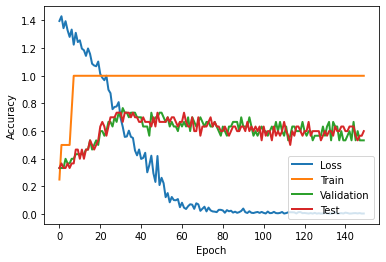

Best Validation Accuracy,  0.7666666666666667
Best Test Accuracy,  0.7333333333333333
Total epoch time:  3.540797710418701
0.7333333333333333 150


In [17]:
args.log_info = True
DATASET_NAME = 'karate'
data, dataset = get_data(DATASET_NAME, DIR=None, log=False, h_score=True, split_no=1); print("")
print(data)

# (row, col) = data.edge_index
# data.edge_index = torch.stack((torch.cat((row, col),dim=0),torch.cat((col, row),dim=0)),dim=0)
# data.edge_index = torch_geometric.utils.coalesce(data.edge_index)
# print(data)

args.recompute = True


if len(data.y.shape) > 1:
    data.y = data.y.argmax(dim=1)        
    num_classes = torch.max(data.y).item()+1
else:
    num_classes = dataset.num_classes

if num_classes!= torch.max(data.y)+1:
    num_classes = torch.max(data.y).item()+1
    
# data.edge_index, _ = add_self_loops(data.edge_index)            
# data.x = torch.cat((data.x, adj_feature(data)), dim=1)
# if args.log_info == True:
#     print(data.x.shape)

    
# if DATASET_NAME in ['Cornell', 'cornell5']:
#     data.edge_index, _ = add_self_loops(data.edge_index)            
    
# if DATASET_NAME in ['Squirrel', 'Chameleon', 'amherst41',
#                     'Cornell','cornell5', 'johnshopkins55']:
#     data.x = torch.cat((data.x, adj_feature(data)), dim=1)
#     if args.log_info == True:
#         print(data.x.shape)


best_acc, num_iteration, _ =  AGSNSperformanceSampler(DATASET_NAME, data, dataset, num_classes, epochs=150, train_neighbors=[8,4], test_neighbors=[8,4])
print(best_acc, num_iteration)

# Batch Experiments

In [ ]:
def batch_experiments(num_run=1):
    
    ALL_DATASETs= [
        "Cornell",
        "Texas",
        "Wisconsin",
        "reed98",
        "amherst41",
        "penn94",
        "Roman-empire",
        "cornell5",
        "Squirrel",
        "johnshopkins55",
        "AmazonProducts",
        "Actor",
        "Minesweeper",
        "Questions",
        "Chameleon",
        "Tolokers",
        "Flickr",
        "Yelp",
        "Amazon-ratings",
        "genius",
        "cora",
        "CiteSeer",
        "dblp",
        "Computers",
        "PubMed",
        "pubmed",
        "Reddit",
        "cora_ml",
        "Cora",
        "Reddit2",
        "CS",
        "Photo",
        "Physics",
        "citeseer"
    ]     
    
    ALL_DATASETs= [
        'cornell5',
    ]

    args.log_info = False
    
    filename = "Results/AGSGNN-NS-2.txt"
    
    for DATASET_NAME in ALL_DATASETs:  
        print(DATASET_NAME, end=' ')
        
        
        result_file = open(filename,'a+')        
        result_file.write(f'{DATASET_NAME} ')
        result_file.close()
                
        accs = []
        itrs = []
                
        for i in range(num_run):
            data, dataset = get_data(DATASET_NAME, DIR=None, log=False, h_score=False, split_no=i)   
            
            #optional for making undirected graph
            (row, col) = data.edge_index
            data.edge_index = torch.stack((torch.cat((row, col),dim=0),torch.cat((col, row),dim=0)),dim=0)
            data.edge_index = torch_geometric.utils.coalesce(data.edge_index)
            
#             if data.num_nodes>100000:
#                 accs.append(-1)
#                 itrs.append(-1)
#                 break
            
            if len(data.y.shape) > 1:
                data.y = data.y.argmax(dim=1)        
                num_classes = torch.max(data.y).item()+1
            else:
                num_classes = dataset.num_classes
            
            if num_classes!= torch.max(data.y)+1:
                num_classes = torch.max(data.y).item()+1
                
            if data.num_nodes<100000:
                max_epochs = 150
            else:
                max_epochs = 20
                
            if DATASET_NAME in ['Squirrel', 'Chameleon','cornell5','penn94','johnshopkins55'
                               ]:
                data.x = torch.cat((data.x, adj_feature(data)), dim=1)
                if args.log_info == True:
                    print(data.x.shape)
                              
            accuracy, itr, _ = AGSNSperformanceSampler(DATASET_NAME, data, dataset, num_classes, epochs=max_epochs, train_neighbors=[8,4], test_neighbors=[8,4])
            
            accs.append(accuracy)
            itrs.append(itr)
            #print(itr, accuracy)
                        
        #print(accs, itrs)
        print(f'acc {np.mean(accs):0.4f} sd {np.std(accs):0.4f} itr {int(np.mean(itrs)):d} sd {int(np.std(itrs)):d}')
        result_file = open(filename,'a+')
        result_file.write(f'acc {np.mean(accs):0.4f} sd {np.std(accs):0.4f} itr {int(np.mean(itrs)):d} sd {int(np.std(itrs)):d}\n')
        result_file.close()
                
# batch_experiments(num_run=5)

## View Learned Representation

In [ ]:
# if __name__ == '__main__':    
    
#     n=7
#     x = torch.Tensor([[1,0],[1,0],[1,0],[0,1],[0,1],[0,1],[0,1]])
#     y = torch.LongTensor([0,0,0, 1, 1, 1, 1])
#     edge_index = torch.LongTensor([[1,2],[1,4],[1,5],[2,1],[3,6],[3,7],[4,5],[4,1],[4,6],[4,7],[5,1],[5,4],[5,6],[6,3],[6,4],[6,5],[6,7],[7,3],[7,4],[7,6]]).T
#     edge_index = edge_index-1
    
#     mask = torch.zeros(n, dtype=torch.bool)
#     mask[[1,3]] = True
    
#     test_data = Data(x = x, y = y, edge_index = edge_index, train_mask = mask, test_mask = mask, val_mask = mask)    
#     print(test_data)
    
    
#     None

In [ ]:
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt

In [ ]:
# model.eval()
# #X = model(data.x.to(device),data.edge_index.to(device), data.weight.to(device))
# X = model(data.x.to(device),data.edge_index.to(device))
# X = X.detach().to('cpu')
# y = data.y.to('cpu')
# X.shape

In [ ]:
# plt.figure(figsize=(10, 10))

# # Create a t-SNE model with 2 components and a perplexity of 30
# tsne = TSNE(n_components=2, perplexity=30, random_state=42, learning_rate='auto', init='random')

# # Fit and transform the data to the 2D t-SNE space
# X_tsne = tsne.fit_transform(X)

# # Plot the data in the 2D t-SNE space, colored by class
# plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y)
# plt.show()